### Imports

In [1]:
import sys
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from torch.autograd import Function
from torch.optim import Adam
from graphviz import Source
from pyeda.boolalg.bdd import bdd2expr

filepath = os.path.abspath('')
sys.path.append(os.path.join(filepath, "..", "..", "compiling_nn"))
from build_odd import compile_nn

### Network and Custom Activation/Loss

In [2]:
class StepFunction(Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.where(input>=0, torch.tensor(1.0), torch.tensor(0.0))
        ctx.save_for_backward(input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = torch.zeros_like(input)
        return grad_input
    
class StepActivation(nn.Module):
    def forward(self, input):
        return StepFunction.apply(input)

class BigNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,25),
            nn.Sigmoid(),
            nn.Linear(25,5),
            nn.Sigmoid(),
            nn.Linear(5,1)
        )
        self.ll = {True: nn.Sigmoid(), False: StepActivation()}

    def forward(self, x):
        x = self.nn(x)
        x = self.ll[self.training](x)
        return x

class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(25,1)
        self.a1 = {True: nn.Sigmoid(), False: StepActivation()}
    
    def forward(self, x):
        x = self.l1(x)
        x = self.a1[self.training](x)
        return x
    
class CombinedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hinet = SmallNet()
        self.add_module("hinet", self.hinet)
        self.lonet = SmallNet()
        self.add_module("lonet", self.lonet)
        self.bignet = BigNet()
        self.add_module("bignet", self.bignet)

    def forward(self, x):
        xh = self.hinet.forward(x)
        xl = self.lonet.forward(x)
        xb = self.bignet.forward(x)

        return xh, xb, xl

class ExpLoss(nn.Module): # https://www.desmos.com/calculator/378bhjqozk
    def __init__(self, lower_bound=0, upper_bound=1, b=1.00, base_pow=None, reduction='mean'):
        super(ExpLoss, self).__init__()
        self.coef_div = upper_bound - lower_bound
        self.coef_mul = b
        self.coef_all = self.coef_mul/self.coef_div
        self.base_pow = base_pow

        self.mean_reduction = reduction=='mean'
        self.sum_reduction = reduction=='sum'

    def forward(self, output, target):
        if self.base_pow:
            loss = torch.abs(torch.pow(exponent=(output - target)*self.coef_all, self=self.base_pow) - 1)
        else:
            loss = torch.abs(torch.exp((output - target)*self.coef_all) - 1)

        if self.mean_reduction:
            loss = torch.mean(loss)
        elif self.sum_reduction:
            loss = torch.sum(loss)

        return loss

In [3]:
df = pd.read_csv("loan_data_set.csv", sep=",")
df = df.drop(columns=["Loan_ID"])

df_y = pd.get_dummies(df[["Loan_Status"]], drop_first=True)
df_x = df.drop(columns=["Loan_Status"])

nunique = df_x.nunique(axis=0)
df_x_mean = df_x.mean(axis=0, numeric_only=True)

for col, n in nunique.items():
    if n > 4:
        df_x[col] = df_x[col].apply(lambda x : min(4, x//(.5*df_x_mean[col])))

df_x = pd.get_dummies(df_x, columns=df_x.columns, drop_first=True)

itrue = df_y.index[df_y["Loan_Status_Y"]==1].tolist()
ifalse = df_y.index[df_y["Loan_Status_Y"]==0].tolist()

swap = len(itrue) > len(ifalse)
if swap:
    itrue,ifalse=ifalse,itrue

ifalse = random.choices(ifalse, k=len(itrue))

if swap:
    itrue,ifalse=ifalse,itrue

print(df_y.iloc[itrue+ifalse].value_counts())

x=torch.Tensor(df_x.iloc[itrue+ifalse].to_numpy(dtype=int))
y=torch.Tensor(df_y.iloc[itrue+ifalse].to_numpy(dtype=int))

print(x.shape, y.shape)

Loan_Status_Y
0                192
1                192
dtype: int64
torch.Size([384, 25]) torch.Size([384, 1])


In [4]:
bignet = BigNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn = nn.BCELoss()
optimizer = Adam(bignet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bignet.train()
    y_pred = bignet(x)
    loss = loss_fn(y_pred, y)

    bignet.zero_grad()
    loss.backward()
    optimizer.step()

    bignet.eval()
    y_pred_step = bignet(x)
    loss_step = loss_fn(y_pred_step, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

0.6367700695991516 29.94791603088379
0.5329001545906067 22.65625
0.41630449891090393 16.14583396911621
0.2552153766155243 6.510416507720947
0.11458873003721237 2.8645832538604736
0.09324260801076889 2.8645832538604736
0.08734429627656937 2.8645832538604736
0.08437949419021606 2.8645832538604736
0.08258961141109467 2.8645832538604736
0.08140506595373154 2.8645832538604736
0.08056601136922836 2.8645832538604736
0.0799456536769867 2.8645832538604736
0.07947327941656113 2.8645832538604736
0.07908038049936295 2.8645832538604736
0.07841210812330246 2.8645832538604736
0.06748658418655396 2.6041667461395264
0.06718572229146957 2.6041667461395264
0.0669914186000824 2.6041667461395264
0.06684038788080215 2.6041667461395264
0.06671706587076187 2.6041667461395264


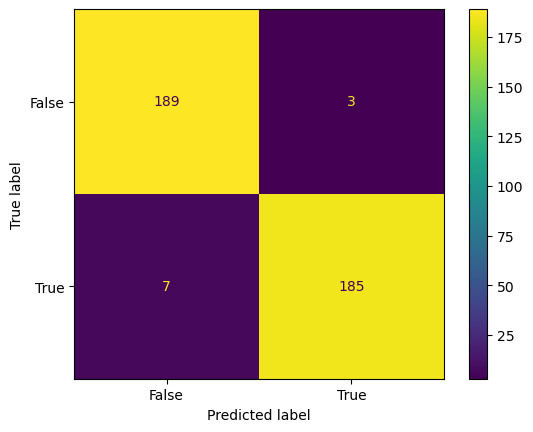

In [5]:
bignet.eval()
y_pred_big = bignet(x).detach().numpy()
confusion_matrix = metrics.confusion_matrix(y, y_pred_big)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [6]:
smallnet = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_small = ExpLoss(base_pow=1.5)
optimizer = Adam(smallnet.parameters(), lr=learning_rate)

y_target = torch.maximum(bignet(x), y).detach()

for epoch in range(max_epoch):
    smallnet.train()
    y_pred_small = smallnet(x)
    loss = loss_fn_small(y_pred_small, y_target)

    smallnet.zero_grad()
    loss.backward()
    optimizer.step()

    smallnet.eval()
    y_pred_step_small = smallnet(x)
    loss_step = loss_fn_small(y_pred_step_small, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

0.17465372383594513 0.1666666567325592
0.17059238255023956 0.1666666567325592
0.16054309904575348 0.1449652761220932
0.1490064263343811 0.1306423544883728
0.14149005711078644 0.1228298619389534
0.13654573261737823 0.1119791567325592
0.13283751904964447 0.1141493022441864
0.1298881620168686 0.110677070915699
0.12729968130588531 0.1132812425494194
0.12415367364883423 0.1067708358168602
0.12140852212905884 0.1072048544883728
0.11926635354757309 0.1028645858168602
0.11749158054590225 0.1028645858168602
0.11596638709306717 0.1015625
0.11463110893964767 0.1002604141831398
0.1134481132030487 0.1002604141831398
0.11238974332809448 0.1032986044883728
0.11143409460783005 0.1032986044883728
0.11056327819824219 0.1015625
0.10976243019104004 0.1015625


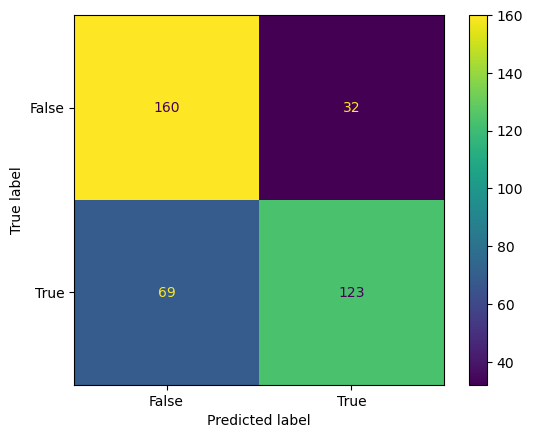

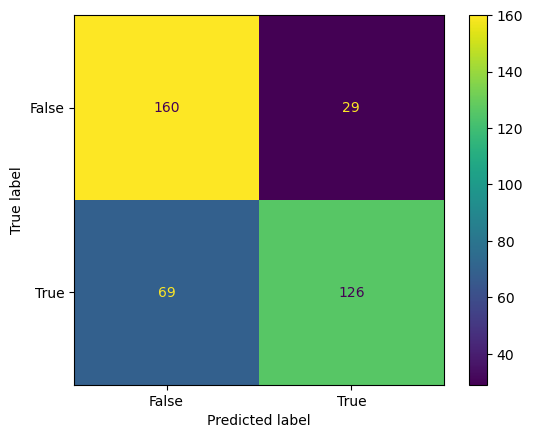

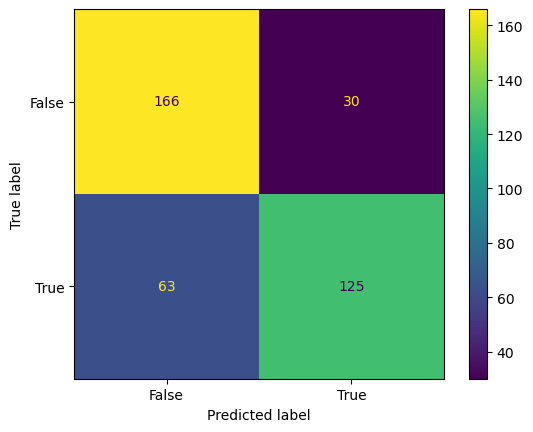

In [7]:
smallnet.eval()
y_pred_small = smallnet(x).detach().numpy()
confusion_matrix_true = metrics.confusion_matrix(y, y_pred_small)
confusion_matrix_target = metrics.confusion_matrix(y_target, y_pred_small)
confusion_matrix_big = metrics.confusion_matrix(y_pred_big, y_pred_small)

cm_display_true   = metrics.ConfusionMatrixDisplay(confusion_matrix_true, display_labels=[False, True])
cm_display_target = metrics.ConfusionMatrixDisplay(confusion_matrix_target, display_labels=[False, True])
cm_display_big    = metrics.ConfusionMatrixDisplay(confusion_matrix_big, display_labels=[False, True])

cm_display_true.plot()
cm_display_target.plot()
cm_display_big.plot()
plt.show()

In [8]:
smallnet = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_small = nn.BCELoss()
optimizer = Adam(smallnet.parameters(), lr=learning_rate)

y_target = torch.minimum(bignet(x), y).detach()

for epoch in range(max_epoch):
    smallnet.train()
    y_pred_small = smallnet(x)
    loss = loss_fn_small(y_pred_small, y_target)

    smallnet.zero_grad()
    loss.backward()
    optimizer.step()

    smallnet.eval()
    y_pred_step_small = smallnet(x)
    loss_step = loss_fn(y_pred_step_small, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

0.6304331421852112 33.85416793823242
0.5984702706336975 28.64583396911621
0.5807562470436096 29.42708396911621
0.5698664784431458 28.64583396911621
0.5631989240646362 28.90625
0.5591395497322083 29.16666603088379
0.5566453337669373 28.90625
0.5550642609596252 28.90625
0.5540017485618591 28.64583396911621
0.553226888179779 28.90625
0.5526093244552612 28.90625
0.5520786643028259 28.64583396911621
0.5515990257263184 28.125
0.5511532425880432 28.125
0.5507345795631409 27.86458396911621
0.5503405928611755 27.60416603088379
0.5499711632728577 27.08333396911621
0.5496268272399902 27.08333396911621
0.5493079423904419 27.08333396911621
0.5490146279335022 26.30208396911621


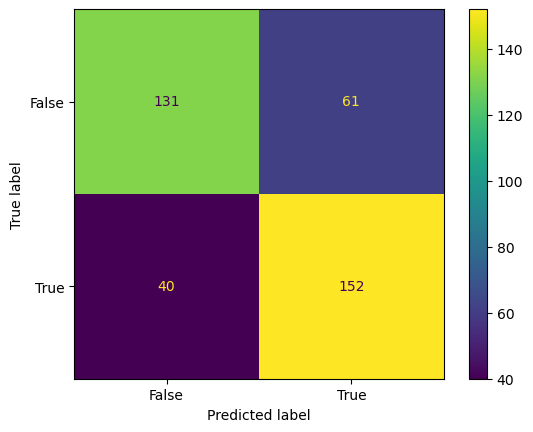

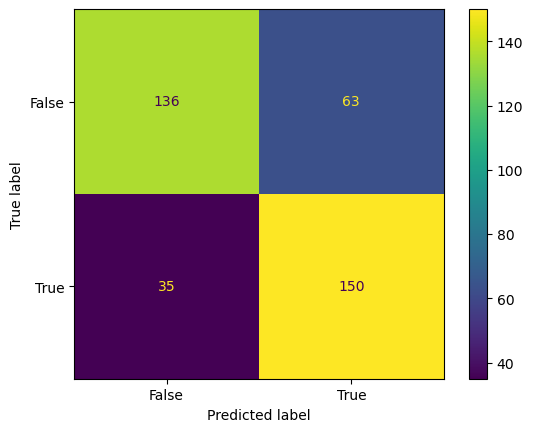

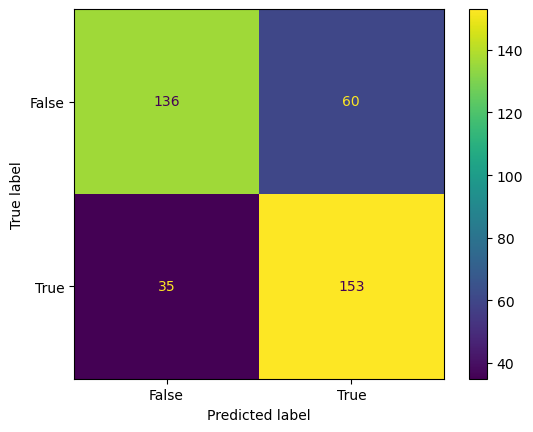

In [9]:
smallnet.eval()
y_pred_small = smallnet(x).detach().numpy()
confusion_matrix_true = metrics.confusion_matrix(y, y_pred_small)
confusion_matrix_target = metrics.confusion_matrix(y_target, y_pred_small)
confusion_matrix_big = metrics.confusion_matrix(y_pred_big, y_pred_small)

cm_display_true   = metrics.ConfusionMatrixDisplay(confusion_matrix_true, display_labels=[False, True])
cm_display_target = metrics.ConfusionMatrixDisplay(confusion_matrix_target, display_labels=[False, True])
cm_display_big    = metrics.ConfusionMatrixDisplay(confusion_matrix_big, display_labels=[False, True])

cm_display_true.plot()
cm_display_target.plot()
cm_display_big.plot()
plt.show()

### Combined networks

In [18]:
combnet = CombinedNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_hi = ExpLoss(base_pow=1.4)
loss_fn_big = nn.BCELoss()
loss_fn_lo = ExpLoss(base_pow=1.4, upper_bound=0, lower_bound=1)
optimizer = Adam(combnet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    combnet.train()
    y_pred_hi, y_pred_big, y_pred_lo = combnet(x)
    loss_hi = loss_fn_hi(y, y_pred_hi)
    loss_lo = loss_fn_lo(y, y_pred_lo)
    loss_big = loss_fn_big(y, y_pred_big)

    combnet.zero_grad()
    loss_big.backward()
    optimizer.step()

    # combnet.eval()
    # y_pred_step_comb = combnet(x)
    # loss_step = loss_fn(y_pred_step_comb, y)
    # if (epoch+1)%50==0:
    #     print(loss.item(), loss_step.item())

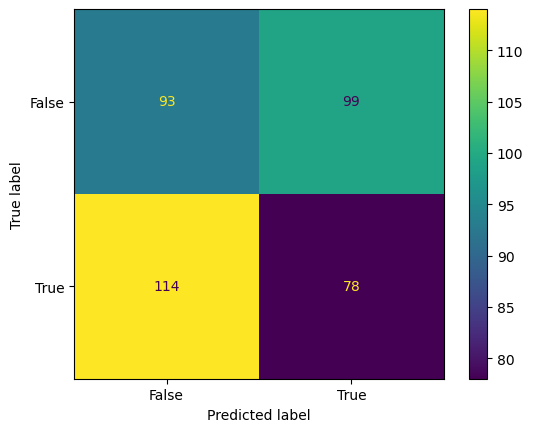

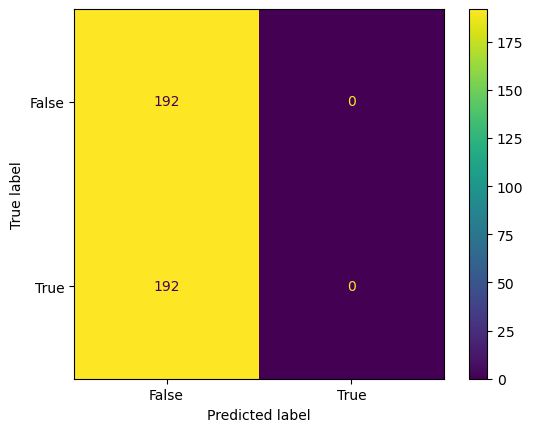

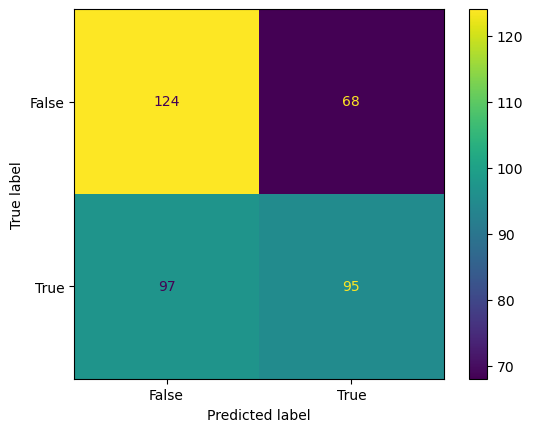

In [19]:
combnet.eval()
# y_pred_comb = combnet(x).detach().numpy()
y_pred_hi   = combnet.hinet(x).detach().numpy()
y_pred_big  = combnet.bignet(x).detach().numpy()
y_pred_lo   = combnet.lonet(x).detach().numpy()
# confusion_matrix_comb  = metrics.confusion_matrix(y, y_pred_comb)
confusion_matrix_hi = metrics.confusion_matrix(y, y_pred_hi)
confusion_matrix_big   = metrics.confusion_matrix(y, y_pred_big)
confusion_matrix_lo = metrics.confusion_matrix(y, y_pred_lo)

# cm_display_comb = metrics.ConfusionMatrixDisplay(confusion_matrix_comb, display_labels=[False, True])
cm_display_hi   = metrics.ConfusionMatrixDisplay(confusion_matrix_hi, display_labels=[False, True])
cm_display_big  = metrics.ConfusionMatrixDisplay(confusion_matrix_big, display_labels=[False, True])
cm_display_lo   = metrics.ConfusionMatrixDisplay(confusion_matrix_lo, display_labels=[False, True])

# cm_display_comb.plot()
cm_display_hi.plot()
cm_display_big.plot()
cm_display_lo.plot()
plt.show()

___
# TESTS

In [ ]:
bignet = BigNet()
smallnet = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_big   = nn.BCELoss()
loss_fn_small = nn.BCELoss()
loss_fn_cross1 = nn.BCELoss()
loss_fn_cross2 = nn.BCELoss()

loss_fn = lambda big, small, true : loss_fn_big(big, true) + loss_fn_small(small, true) + loss_fn_cross1(big, small)

optimizer_big = Adam(bignet.parameters(), lr=learning_rate)
optimizer_small = Adam(smallnet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bignet.train()
    smallnet.train()

    y_pred_big = bignet(x)
    y_pred_small = smallnet(x)
    loss = loss_fn(y_pred_big, y_pred_small, y)

    bignet.zero_grad()
    smallnet.zero_grad()

    loss.backward()

    optimizer_big.step()
    optimizer_small.step()

    bignet.eval()
    smallnet.eval()

    y_pred_step_big = bignet(x)
    y_pred_step_small = smallnet(x)
    loss_step = loss_fn(y_pred_step_big, y_pred_step_small, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

1.913287878036499 72.91666412353516
1.743379831314087 66.14583587646484
1.6078715324401855 64.0625
1.504347324371338 59.375
1.4429681301116943 57.291664123535156
1.407790184020996 56.770835876464844
1.3756561279296875 55.208335876464844
1.3572132587432861 53.64583206176758
1.3442713022232056 53.64583206176758
1.3355039358139038 54.16666793823242
1.3293886184692383 54.16666793823242
1.3252218961715698 53.645835876464844
1.3216872215270996 53.645835876464844
1.3192905187606812 53.125
1.3172621726989746 52.604164123535156
1.315847396850586 52.083335876464844
1.3144252300262451 51.5625
1.3137129545211792 52.083335876464844
1.312450885772705 51.041664123535156
1.311665415763855 51.041664123535156


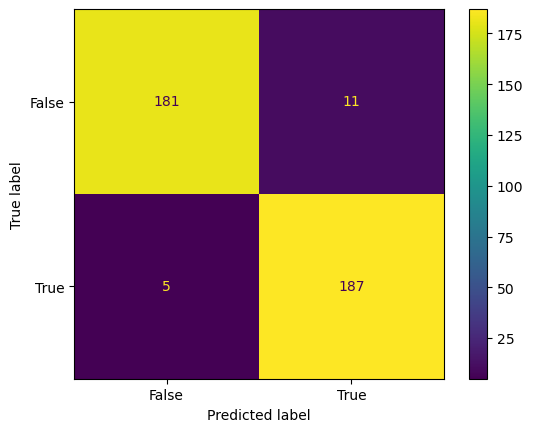

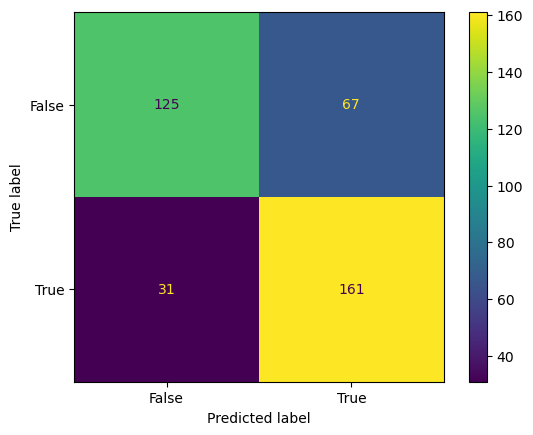

In [ ]:
bignet.eval()
y_pred_big = bignet(x).detach().numpy()
confusion_matrix = metrics.confusion_matrix(y, y_pred_big)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()
smallnet.eval()
y_pred_small = smallnet(x).detach().numpy()
confusion_matrix = metrics.confusion_matrix(y, y_pred_small)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

1. si bignet = smallnet = 1 -> super
2. si bignet = smallnet = 0 -> bien
3. si bignet = 0, smallnet = 1 -> pas ouf
4. si bignet = 1, smallnet = 0 -> pas bien

======

idées functions :

1. ~~2*b - s~~
    <!-- 1. 2*1-1 = 1 
    2. 2*0-0 = 0
    3. 2*0-1 = -1
    4. 2*1-0 = 2 -->

2. loss b, pred + loss s, pred + loss b, s